In [1]:
# Verify dependencies are available (all packages are installed system-wide in Python 3.12.12)
import sys
print(f"Python version: {sys.version}")
print(f"Python executable: {sys.executable}")

try:
    import pandas as pd
    import numpy as np
    import sklearn
    import matplotlib
    import seaborn as sns
    import transformers
    import torch
    import datasets
    import sqlalchemy
    import pydantic_settings
    print("✓ All required packages are available!")
    print(f"  - pandas: {pd.__version__}")
    print(f"  - numpy: {np.__version__}")
    print(f"  - scikit-learn: {sklearn.__version__}")
    print(f"  - matplotlib: {matplotlib.__version__}")
    print(f"  - seaborn: {sns.__version__}")
    print(f"  - transformers: {transformers.__version__}")
    print(f"  - torch: {torch.__version__}")
except ImportError as e:
    print(f"❌ Missing package: {e}")
    print("Run: python3 -m pip install <package_name>")

Python version: 3.12.12 (main, Oct  9 2025, 11:07:00) [Clang 17.0.0 (clang-1700.0.13.3)]
Python executable: /usr/local/opt/python@3.12/bin/python3.12


✓ All required packages are available!
  - pandas: 2.3.3
  - numpy: 1.26.4
  - scikit-learn: 1.7.2
  - matplotlib: 3.8.2
  - seaborn: 0.13.0
  - transformers: 4.57.3
  - torch: 2.2.2


In [2]:
# Load training data with proper error handling
import sys
from pathlib import Path
sys.path.insert(0, str(Path('../../')))

from ml.utils.data_loader import load_document_data
import pandas as pd

print("=" * 60)
print("Loading training data...")
print("=" * 60)

try:
    df = load_document_data()
    
    # Safety check: ensure df is a DataFrame
    if df is None:
        print("⚠️ Warning: load_document_data returned None. Creating minimal sample...")
        df = pd.DataFrame({
            'text': [
                'Invoice #001\nDate: 2024-01-01\nAmount: $100',
                'Purchase Order PO-001\nSupplier: ABC Corp',
                'Receipt #RCP-001\nPayment: $50\nThank you!'
            ],
            'label': ['invoice', 'purchase_order', 'receipt']
        })
    
    # Verify df has required columns
    if 'text' not in df.columns or 'label' not in df.columns:
        print("⚠️ Warning: DataFrame missing required columns. Creating sample...")
        df = pd.DataFrame({
            'text': [
                'Invoice #001\nDate: 2024-01-01\nAmount: $100',
                'Purchase Order PO-001\nSupplier: ABC Corp',
                'Receipt #RCP-001\nPayment: $50\nThank you!'
            ],
            'label': ['invoice', 'purchase_order', 'receipt']
        })
    
    print(f"\n✓ Dataset loaded successfully!")
    print(f"  Shape: {df.shape}")
    print(f"\n  Label distribution:")
    print(df['label'].value_counts())
    print(f"\n  First few samples:")
    print(df.head())
    print(f"\n  Sample text length: {df['text'].str.len().describe()}")
    
except Exception as e:
    print(f"❌ Error loading data: {e}")
    print("Creating minimal sample data...")
    df = pd.DataFrame({
        'text': [
            'Invoice #001\nDate: 2024-01-01\nAmount: $100',
            'Purchase Order PO-001\nSupplier: ABC Corp',
            'Receipt #RCP-001\nPayment: $50\nThank you!',
            'Quotation QT-001\nDate: 2024-01-15\nEstimate: $500',
            'Delivery Order DO-001\nDate: 2024-01-20\nReceived: 10 units'
        ],
        'label': ['invoice', 'purchase_order', 'receipt', 'quotation', 'delivery_order']
    })
    print(f"Created sample dataset with {len(df)} samples")
    print(f"Shape: {df.shape}")


Loading training data...


Could not load from database: (psycopg2.OperationalError) connection to server at "localhost" (::1), port 5432 failed: Connection refused
	Is the server running on that host and accepting TCP/IP connections?
connection to server at "localhost" (127.0.0.1), port 5432 failed: Connection refused
	Is the server running on that host and accepting TCP/IP connections?

(Background on this error at: https://sqlalche.me/e/20/e3q8)
No local data found. Attempting to download sample data from public datasets...
Trying Hugging Face datasets...
  Trying ag_news...


  ag_news failed: BuilderConfig ParquetConfig(name='default', version=0.0.0, data_dir=None, data_files={'train': ['hf:...
  Trying yelp_review_full...


  yelp_review_full failed: BuilderConfig ParquetConfig(name='yelp_review_full', version=0.0.0, data_dir=None, data_files={'trai...
  Trying amazon_polarity...


  amazon_polarity failed: BuilderConfig ParquetConfig(name='amazon_polarity', version=0.0.0, data_dir=None, data_files={'train...
Trying Kaggle datasets...
  Kaggle authentication/download failed: Could not find kaggle.json. Make sure it's located in /Users/ads/.kaggle. Or use the environment method.
Trying Google Drive...


Trying public dataset URL...
Download failed. Generating sample data...

✓ Dataset loaded successfully!
  Shape: (30, 2)

  Label distribution:
label
invoice           9
purchase_order    6
receipt           6
quotation         6
delivery_order    3
Name: count, dtype: int64

  First few samples:
                                                text    label
0  Invoice #INV-001\nDate: 2024-01-15\nAmount Due...  invoice
1  invoice #inv-001\ndate: 2024-01-15\namount due...  invoice
2  INVOICE #INV-001\nDATE: 2024-01-15\nAMOUNT DUE...  invoice
3  INVOICE\nBill To: ABC Company\nTotal Amount: $...  invoice
4  invoice\nbill to: abc company\ntotal amount: $...  invoice

  Sample text length: count    30.000000
mean     79.700000
std       4.219413
min      73.000000
25%      77.000000
50%      80.000000
75%      82.000000
max      87.000000
Name: text, dtype: float64


## 2. Train Document Classification Model


In [3]:
import numpy as np
from pathlib import Path
import pickle
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.naive_bayes import MultinomialNB
from sklearn.svm import SVC
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
import matplotlib.pyplot as plt
import seaborn as sns

# Set paths
BASE_DIR = Path('../')
MODELS_DIR = BASE_DIR / 'models' / 'document_classifier'
MODELS_DIR.mkdir(parents=True, exist_ok=True)

print(f"Models directory: {MODELS_DIR}")


Models directory: ../models/document_classifier


### Split and Prepare Data


In [4]:
# Split data
# Check if we have enough samples per class for stratified split
label_counts = df['label'].value_counts()
min_samples = label_counts.min()

if min_samples >= 2 and len(df) >= 10:
    # Use stratified split if we have enough samples
    X_train, X_test, y_train, y_test = train_test_split(
        df['text'], df['label'], test_size=0.2, random_state=42, stratify=df['label']
    )
else:
    # Use regular split for small datasets
    print(f"⚠️ Dataset too small for stratified split (min class: {min_samples} samples). Using regular split.")
    X_train, X_test, y_train, y_test = train_test_split(
        df['text'], df['label'], test_size=0.2, random_state=42
    )

print(f"Training set: {len(X_train)} samples")
print(f"Test set: {len(X_test)} samples")
print(f"\nTraining label distribution:")
print(y_train.value_counts())


Training set: 24 samples
Test set: 6 samples

Training label distribution:
label
invoice           7
purchase_order    5
quotation         5
receipt           5
delivery_order    2
Name: count, dtype: int64


### Train Model


Training Naive Bayes classifier...

✓ Model trained successfully!
Accuracy: 1.0000

Classification Report:
                precision    recall  f1-score   support

delivery_order       1.00      1.00      1.00         1
       invoice       1.00      1.00      1.00         2
purchase_order       1.00      1.00      1.00         1
     quotation       1.00      1.00      1.00         1
       receipt       1.00      1.00      1.00         1

      accuracy                           1.00         6
     macro avg       1.00      1.00      1.00         6
  weighted avg       1.00      1.00      1.00         6



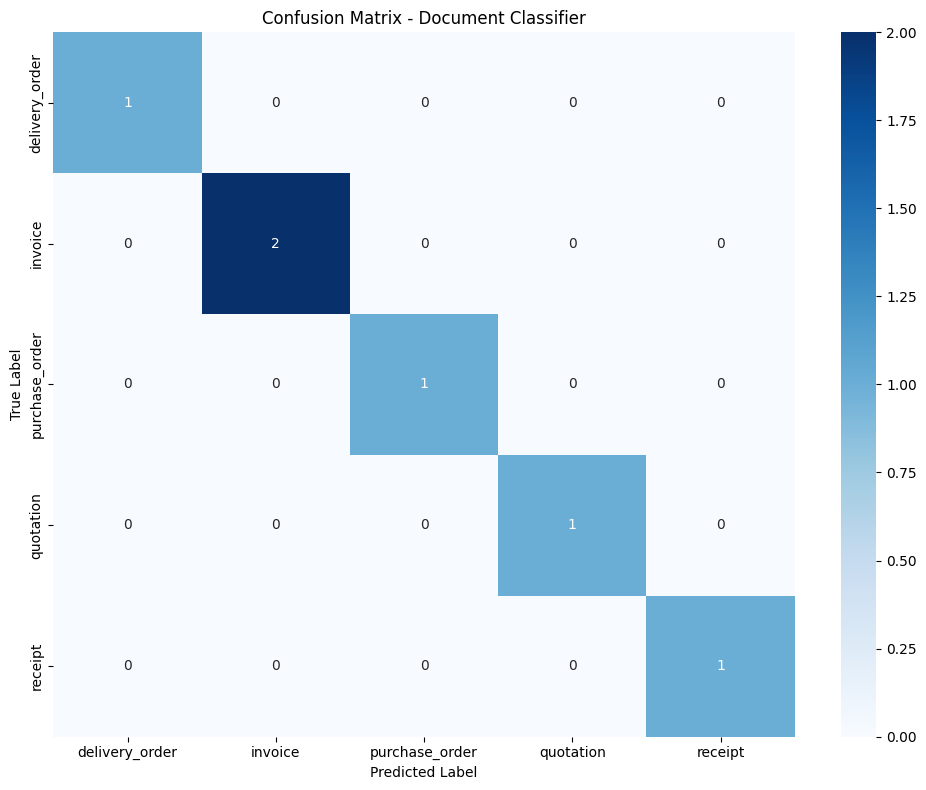

Model saved to ../models/document_classifier

✓ Model saved to ../models/document_classifier


In [ ]:
# Vectorize text
vectorizer = TfidfVectorizer(max_features=5000, ngram_range=(1, 2), stop_words='english')
X_train_vec = vectorizer.fit_transform(X_train)
X_test_vec = vectorizer.transform(X_test)

# Train Naive Bayes model
print("Training Naive Bayes classifier...")
nb_model = MultinomialNB()
nb_model.fit(X_train_vec, y_train)

# Evaluate
y_pred = nb_model.predict(X_test_vec)
accuracy = accuracy_score(y_test, y_pred)

print(f"\n✓ Model trained successfully!")
print(f"Accuracy: {accuracy:.4f}")
print("\nClassification Report:")
print(classification_report(y_test, y_pred))

# Confusion matrix
cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
            xticklabels=nb_model.classes_, yticklabels=nb_model.classes_)
plt.title('Confusion Matrix - Document Classifier')
plt.ylabel('True Label')
plt.xlabel('Predicted Label')
plt.tight_layout()
plt.savefig(MODELS_DIR / 'confusion_matrix.png')
plt.show()

# Save model
from ml.utils.model_saver import save_model
save_model(nb_model, vectorizer, MODELS_DIR, accuracy)

print(f"\n✓ Model saved to {MODELS_DIR}")


### Test the Model


In [ ]:
# Test with new documents
test_documents = [
    "Invoice #INV-2024-123\nDate: 2024-12-20\nAmount: $1,500.00\nDue: 2025-01-20",
    "Purchase Order PO-456\nSupplier: XYZ Corp\nOrder Date: 2024-12-19\nItems: 50 units",
    "Receipt #RCP-789\nPayment Date: 2024-12-18\nAmount Paid: $250.00\nThank you!",
    "Quotation #QT-001\nEstimate: $5,000\nValid until: 2025-01-15",
    "Delivery Order DO-2024-001\nReceived: 100 units\nDate: 2024-12-17"
]

print("Testing document classifier:\n")
for doc in test_documents:
    test_vec = vectorizer.transform([doc])
    pred = nb_model.predict(test_vec)[0]
    proba = nb_model.predict_proba(test_vec)[0]
    confidence = max(proba)
    
    print(f"Document: {doc[:50]}...")
    print(f"Prediction: {pred} (confidence: {confidence:.2%})")
    print(f"All probabilities:")
    for label, prob in zip(nb_model.classes_, proba):
        print(f"  {label}: {prob:.2%}")
    print()


Testing document classifier:

Document: Invoice #INV-2024-123
Date: 2024-12-20
Amount: $1,...
Prediction: invoice (confidence: 39.57%)
All probabilities:
  delivery_order: 6.52%
  invoice: 39.57%
  purchase_order: 21.29%
  quotation: 16.83%
  receipt: 15.78%

Document: Purchase Order PO-456
Supplier: XYZ Corp
Order Dat...
Prediction: purchase_order (confidence: 61.27%)
All probabilities:
  delivery_order: 5.85%
  invoice: 13.66%
  purchase_order: 61.27%
  quotation: 9.44%
  receipt: 9.78%

Document: Receipt #RCP-789
Payment Date: 2024-12-18
Amount P...
Prediction: receipt (confidence: 48.27%)
All probabilities:
  delivery_order: 5.85%
  invoice: 20.74%
  purchase_order: 12.51%
  quotation: 12.64%
  receipt: 48.27%

Document: Quotation #QT-001
Estimate: $5,000
Valid until: 20...
Prediction: quotation (confidence: 42.24%)
All probabilities:
  delivery_order: 6.46%
  invoice: 25.98%
  purchase_order: 13.08%
  quotation: 42.24%
  receipt: 12.25%

Document: Delivery Order DO-2024-001
Receiv